# Metrics in probabilistic forecasting

In point estimate forecasting, the model outputs a single value that ideally represents the most likely value of the time series at future steps. In this scenario, the quality of the predictions can be assessed by comparing the predicted value with the true value of the series. Examples of metrics used for this purpose includes Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE).

In probabilistic forecasting, however, the model does not produce a single value, but rather a representation of the entire distribution of possible predicted values. In practice, this is often represented by a sample of the underlying distribution (e.g. 50 possible predicted values) or by specific quantiles that capture most of the information in the distribution. This approach provides richer insights by allowing the creation of prediction intervals - ranges within which the true value is likely to fall.

In this context, the quality of the predictions cannot be assessed using the same metrics as in point estimate forecasting. Instead, we need to use metrics that are specifically designed to evaluate the quality of probabilistic forecasts.

This notebook explores some metrics that can be used to assess the quality of probabilistic forecasts:

+ Coverage: The proportion of the true values that fall within the prediction intervals.

+ Interval width: The average width of the prediction intervals.

+ Interval area: The area covered by the prediction intervals.

+ Continuous Ranked Probability Score (CRPS): A scoring rule that measures the distance between the predicted cumulative distribution function and the true cumulative distribution function.

In general, the goal is to produce prediction intervals that are as narrow as possible while still capturing the true values with the desired probability. This is a trade-off between the width of the intervals and the coverage of the true values.

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

<p>For more examples on how to use probabilistic forecasting, check out the following articles:</p>
<ul>
    <li>
        <a href="https://cienciadedatos.net/documentos/py42-probabilistic-forecasting" target="_blank">
            Probabilistic forecasting with machine learning
        </a>
    </li>
    <li>
        <a href="https://cienciadedatos.net/documentos/py60-probabilistic-forecasting-prediction-intervals-multi-step-forecasting" target="_blank">
            Probabilistic forecasting: prediction intervals for multi-step time series forecasting
        </a>
    </li>
    <li>
        <a href="../faq/probabilistic-forecasting-crps-score.html" target="_blank">
            Continuous Ranked Probability Score (CRPS) in probabilistic forecasting
        </a>
    </li>
</ul>

</div>

## Libraries and data

In [1]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from skforecast.plot import set_dark_theme
from skforecast.plot import plot_prediction_intervals
from skforecast.plot import plot_residuals

# Modelling and Forecasting
# ==============================================================================
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from feature_engine.datetime import DatetimeFeatures
from feature_engine.creation import CyclicalFeatures
from feature_engine.timeseries.forecasting import LagFeatures
from feature_engine.timeseries.forecasting import WindowFeatures
from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_forecaster
from skforecast.preprocessing import RollingFeatures
from skforecast.metrics import calculate_coverage, crps_from_quantiles

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

In [2]:
# Load data
# ==============================================================================
data = fetch_dataset('ett_m2', raw=True)
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')
data = data.asfreq('15min')
data = data.resample(rule="1h", closed="left", label="right").mean()
data.head(3)

ett_m2
------
Data from an electricity transformer station was collected between July 2016 and
July 2018 (2 years x 365 days x 24 hours x 4 intervals per hour = 70,080 data
points). Each data point consists of 8 features, including the date of the
point, the predictive value "Oil Temperature (OT)", and 6 different types of
external power load features: High UseFul Load (HUFL), High UseLess Load (HULL),
Middle UseFul Load (MUFL), Middle UseLess Load (MULL), Low UseFul Load (LUFL),
Low UseLess Load(LULL).
Zhou, Haoyi & Zhang, Shanghang & Peng, Jieqi & Zhang, Shuai & Li, Jianxin &
Xiong, Hui & Zhang, Wancai. (2020). Informer: Beyond Efficient Transformer for
Long Sequence Time-Series Forecasting.
[10.48550/arXiv.2012.07436](https://arxiv.org/abs/2012.07436).
https://github.com/zhouhaoyi/ETDataset
Shape of the dataset: (69680, 8)


,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
date,,,,,,,
2016-07-01 01:00:00,38.784501,10.88975,34.753500,8.55100,4.12575,1.26050,37.83825
2016-07-01 02:00:00,36.041249,9.44475,32.696001,7.13700,3.59025,0.62900,36.84925
2016-07-01 03:00:00,38.240000,11.41350,35.343501,9.10725,3.06000,0.31175,35.91575


In [3]:
# Split train-validation-test
# ==============================================================================
end_train = '2017-10-01 23:59:00'
end_validation = '2018-04-03 23:59:00'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2016-07-01 01:00:00 --- 2017-10-01 23:00:00  (n=10991)
Dates validacion : 2017-10-02 00:00:00 --- 2018-04-03 23:00:00  (n=4416)
Dates test       : 2018-04-04 00:00:00 --- 2018-06-26 20:00:00  (n=2013)


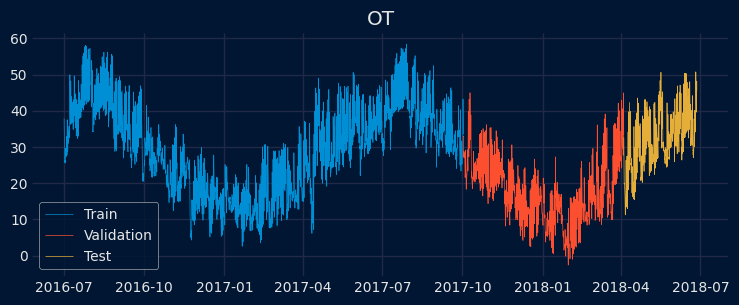

In [ ]:
# Plot partitions of the target series
# ==============================================================================
set_dark_theme()
plt.rcParams['lines.linewidth'] = 0.5
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(data_train['OT'], label='Train')
ax.plot(data_val['OT'], label='Validation')
ax.plot(data_test['OT'], label='Test')
ax.set_title('Oil Temperature')
ax.legend();

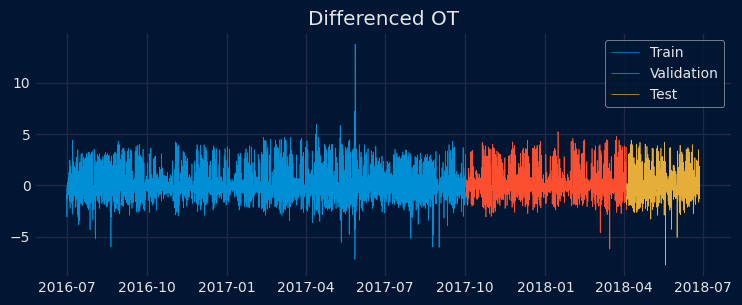

In [ ]:
# Plot partitions after differencing
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(data_train['OT'].diff(1), label='Train')
ax.plot(data_val['OT'].diff(1), label='Validation')
ax.plot(data_test['OT'].diff(1), label='Test')
ax.set_title('Differenced Oil Temperature')
ax.legend();

In [6]:
# Calendar features
# ==============================================================================
features_to_extract = [
    'year',
    'month',
    'week',
    'day_of_week',
    'hour'
]
calendar_transformer = DatetimeFeatures(
    variables           = 'index',
    features_to_extract = features_to_extract,
    drop_original       = False,
)

# Lags of exogenous variables
# ==============================================================================
lag_transformer = LagFeatures(
    variables = ["HUFL", "MUFL", "MULL", "HULL", "LUFL", "LULL"],
    periods   = [1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 42]
)

# Rolling features for exogenous variables
# ==============================================================================
wf_transformer = WindowFeatures(
    variables = ["HUFL", "MUFL", "MULL", "HULL", "LUFL", "LULL"],
    window    = ["1D", "7D"],
    functions = ["mean", "max", "min"],
    freq      = "1h",
)

# Cliclical encoding of calendar features
# ==============================================================================
features_to_encode = [
    "month",
    "week",
    "day_of_week",
    "hour",
]
max_values = {
    "month": 12,
    "week": 52,
    "day_of_week": 7,
    "hour": 24,
}
cyclical_encoder = CyclicalFeatures(
                       variables     = features_to_encode,
                       max_values    = max_values,
                       drop_original = True
                   )

exog_transformer = make_pipeline(
                       calendar_transformer,
                       lag_transformer,
                       wf_transformer,
                       cyclical_encoder
                   )
display(exog_transformer)

data = exog_transformer.fit_transform(data)
# Remove rows with NaNs created by lag features
data = data.dropna()
display(data.head(3))

Pipeline(steps=[('datetimefeatures',
                 DatetimeFeatures(drop_original=False,
                                  features_to_extract=['year', 'month', 'week',
                                                       'day_of_week', 'hour'],
                                  variables='index')),
                ('lagfeatures',
                 LagFeatures(periods=[1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14,
                                      15, 16, 17, 18, 19, 20, 21, 23, 24, 42],
                             variables=['HUFL', 'MUFL', 'MULL', 'HULL', 'LUFL',
                                        'LULL'])),
                ('windowfeatures',
                 WindowFeatures(freq='1h', functions=['mean', 'max', 'min'],
                                variables=['HUFL', 'MUFL', 'MULL', 'HULL',
                                           'LUFL', 'LULL'],
                                window=['1D', '7D'])),
                ('cyclicalfeatures',
                 CyclicalFeatures(drop_original=True,
                                  max_values={'day_of_week': 7, 'hour': 24,
                                              'month': 12, 'week': 52},
                                  variables=['month', 'week', 'day_of_week',
                                             'hour']))])

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT,year,HUFL_lag_1,MUFL_lag_1,...,LULL_window_7D_max,LULL_window_7D_min,month_sin,month_cos,week_sin,week_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos
date,,,,,,,,,,,,,,,,,,,,,
2016-07-02 19:00:00,33.6330,9.08900,29.874751,6.95600,3.753,0.61025,28.719500,2016,32.5440,29.017001,...,1.2605,0.0,-0.5,-0.866025,1.224647e-16,-1.0,-0.974928,-0.222521,-0.965926,0.258819
2016-07-02 20:00:00,31.7065,7.72750,27.884500,5.63600,3.753,0.67425,29.103875,2016,33.6330,29.874751,...,1.2605,0.0,-0.5,-0.866025,1.224647e-16,-1.0,-0.974928,-0.222521,-0.866025,0.500000
2016-07-02 21:00:00,31.8110,7.81125,27.362000,5.18025,4.435,1.42075,29.598500,2016,31.7065,27.884500,...,1.2605,0.0,-0.5,-0.866025,1.224647e-16,-1.0,-0.974928,-0.222521,-0.707107,0.707107


In [7]:
# Exogenous features
# ==============================================================================
lags = [1, 2, 3, 4, 5, 6, 9, 12, 15, 17, 20, 23, 24, 42]
exog_features = [
    'HUFL', 'HUFL_lag_1', 'HUFL_lag_12', 'HUFL_lag_13', 'HUFL_lag_15', 'HUFL_lag_19',
    'HUFL_lag_2', 'HUFL_lag_20', 'HUFL_lag_23', 'HUFL_lag_4', 'HUFL_lag_5', 'HUFL_lag_9',
    'HUFL_window_1D_mean', 'HULL', 'HULL_lag_1', 'HULL_lag_12', 'HULL_lag_14',
    'HULL_lag_15', 'HULL_lag_2', 'HULL_lag_20', 'HULL_lag_21', 'HULL_lag_23',
    'HULL_lag_3', 'HULL_lag_4', 'HULL_window_1D_mean', 'LUFL', 'LUFL_lag_1',
    'LUFL_lag_10', 'LUFL_lag_15', 'LUFL_lag_19', 'LUFL_lag_2', 'LUFL_lag_20',
    'LUFL_lag_23', 'LUFL_lag_3', 'LUFL_lag_4', 'LUFL_lag_5', 'LUFL_window_1D_mean',
    'LULL', 'LULL_lag_1', 'LULL_lag_12', 'LULL_lag_13', 'LULL_lag_14', 'LULL_lag_18',
    'LULL_lag_19', 'LULL_lag_20', 'LULL_lag_21', 'LULL_lag_23', 'LULL_lag_24',
    'LULL_lag_4', 'LULL_lag_5', 'LULL_lag_6', 'LULL_window_1D_max', 'LULL_window_1D_min',
    'MUFL', 'MUFL_lag_1', 'MUFL_lag_11', 'MUFL_lag_12', 'MUFL_lag_13', 'MUFL_lag_15',
    'MUFL_lag_2', 'MUFL_lag_20', 'MUFL_lag_23', 'MUFL_lag_4', 'MUFL_lag_9',
    'MUFL_window_1D_mean', 'MULL', 'MULL_lag_1', 'MULL_lag_11', 'MULL_lag_12',
    'MULL_lag_13', 'MULL_lag_14', 'MULL_lag_15', 'MULL_lag_17', 'MULL_lag_19',
    'MULL_lag_2', 'MULL_lag_20', 'MULL_lag_3', 'MULL_lag_4', 'MULL_lag_5', 'MULL_lag_9',
    'MULL_window_1D_mean', 'MULL_window_1D_min', 'MULL_window_7D_mean', 'day_of_week_sin',
    'hour_cos', 'hour_sin', 'month_cos', 'month_sin', 'week_cos', 'week_sin', 'year'
]

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

The lags, features and hyperparameters used in this document were selected after a hyperparameter optimization and feature selection process. For a more detailed visit the full document <a href="https://cienciadedatos.net/documentos/py60-probabilistic-forecasting-prediction-intervals-multi-step-forecasting">Probabilistic forecasting: prediction intervals for multi-step time series forecasting</a>.

</div>

## Probabilistic forecasting

In [ ]:
# Create forecaster
# ==============================================================================
window_features = RollingFeatures(stats=['mean', 'min', 'max'], window_sizes=24)
forecaster = ForecasterRecursive(
                 regressor       = Ridge(random_state=15926, alpha=1.1075),
                 lags            = lags,
                 window_features = window_features,
                 differentiation = 1,
                 binner_kwargs   = {'n_bins': 10}
             )

  0%|          | 0/184 [00:00<?, ?it/s]

,mean_absolute_error
0,2.382001


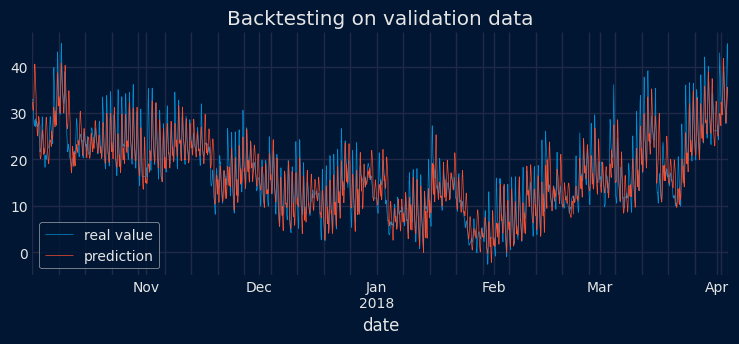

In [ ]:
# Backtesting on validation data to obtain out-sample residuals
# ==============================================================================
cv = TimeSeriesFold(
         initial_train_size = len(data.loc[:end_train, :]),
         steps              = 24,  # all hours of next day
         differentiation    = 1,
     )

metric_val, predictions_val = backtesting_forecaster(
                                  forecaster    = forecaster,
                                  y             = data.loc[:end_validation, 'OT'],
                                  exog          = data.loc[:end_validation, exog_features],
                                  cv            = cv,
                                  metric        = 'mean_absolute_error',
                                  n_jobs        = 'auto',
                                  verbose       = False,
                                  show_progress = True
                              )

display(metric_val)
fig, ax = plt.subplots(figsize=(8, 3))
data.loc[end_train:end_validation, 'OT'].plot(ax=ax, label='real value')
predictions_val['pred'].plot(ax=ax, label='prediction')
ax.set_title("Backtesting on validation data")
ax.legend();

positive    2462
negative    1954
Name: count, dtype: int64


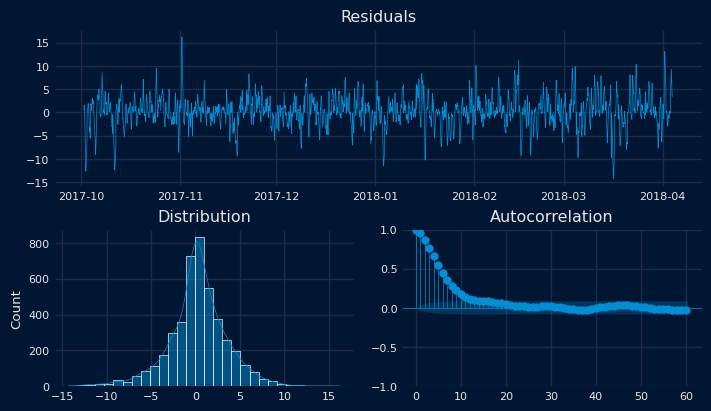

In [10]:
# Out-sample residuals distribution
# ==============================================================================
residuals = data.loc[predictions_val.index, 'OT'] - predictions_val['pred']
print(pd.Series(np.where(residuals < 0, 'negative', 'positive')).value_counts())
plt.rcParams.update({'font.size': 8})
_ = plot_residuals(residuals=residuals, figsize=(7, 4))

In [11]:
# Store out-sample residuals in the forecaster
# ==============================================================================
forecaster.fit(y=data.loc[:end_train, 'OT'], exog=data.loc[:end_train, exog_features])
forecaster.set_out_sample_residuals(
    y_true = data.loc[predictions_val.index, 'OT'], 
    y_pred = predictions_val['pred']
)

In [12]:
# Backtesting with prediction intervals in test data using out-sample residuals
# ==============================================================================
cv = TimeSeriesFold(
         initial_train_size = len(data.loc[:end_validation, :]),
         steps              = 24,  # all hours of next day
         differentiation    = 1
     )

metric, predictions = backtesting_forecaster(
                          forecaster              = forecaster,
                          y                       = data['OT'],
                          exog                    = data[exog_features],
                          cv                      = cv,
                          metric                  = 'mean_absolute_error',
                          interval                = [10, 90],  # 80% prediction interval
                          interval_method         = 'bootstrapping',
                          n_boot                  = 150,
                          use_in_sample_residuals = False,  # Use out-sample residuals
                          use_binned_residuals    = True,
                          n_jobs                  = 'auto',
                          verbose                 = False,
                          show_progress           = True
                      )
display(metric)
predictions.head(5)

  0%|          | 0/84 [00:00<?, ?it/s]

,mean_absolute_error
0,2.872448


,pred,lower_bound,upper_bound
2018-04-04 00:00:00,32.748221,32.293918,33.421547
2018-04-04 01:00:00,31.947644,31.428145,33.195005
2018-04-04 02:00:00,31.052970,30.153244,32.860915
2018-04-04 03:00:00,30.109002,28.482297,32.571251
2018-04-04 04:00:00,29.229875,27.802629,32.305870


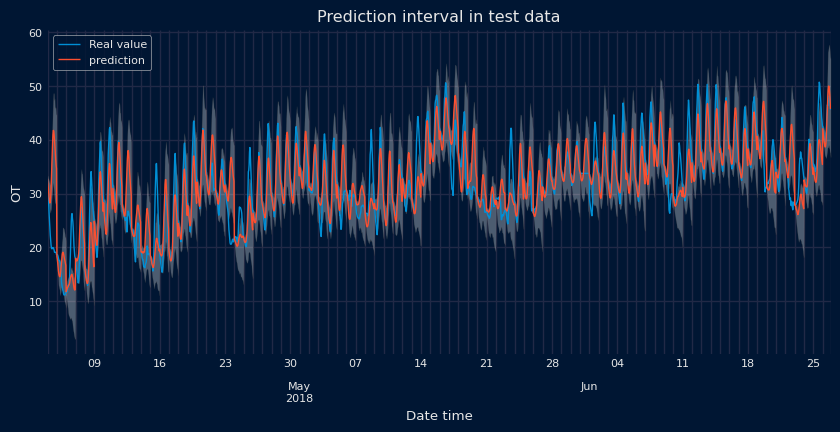

In [13]:
# Plot intervals
# ==============================================================================
plt.rcParams['lines.linewidth'] = 1
fig, ax = plt.subplots(figsize=(9, 4))
plot_prediction_intervals(
    predictions     = predictions,
    y_true          = data_test,
    target_variable = "OT",
    initial_x_zoom  = None,
    title           = "Prediction interval in test data",
    xaxis_title     = "Date time",
    yaxis_title     = "OT",
    ax              = ax
)
fill_between_obj = ax.collections[0]
fill_between_obj.set_facecolor('white')
fill_between_obj.set_alpha(0.3)

In [ ]:
# Empirical interval coverage (on test data)
# ==============================================================================
coverage = calculate_coverage(
               y_true      = data.loc[end_validation:, 'OT'],
               lower_bound = predictions["lower_bound"], 
               upper_bound = predictions["upper_bound"]
           )
print(f"Predicted interval coverage: {round(100 * coverage, 2)} %")

# Mean widht and ara of the interval
# ==============================================================================
area = (predictions["upper_bound"] - predictions["lower_bound"]).sum()
mean_width = (predictions["upper_bound"] - predictions["lower_bound"]).mean()
print(f"Area of the interval: {round(area, 2)}")
print(f"Mean width of the interval: {round(mean_width, 2)}")

Predicted interval coverage: 80.87 %
Area of the interval: 19873.9
Mean width of the interval: 9.87


## Prediction of multiple intervals

The `backtesting_forecaster` function not only allows to estimate a single prediction interval, but also to estimate multiple quantiles (percentiles) from which multiple prediction intervals can be constructed. This is useful to evaluate the quality of the prediction intervals for a range of probabilities.

Several percentiles are predicted and from these, prediction intervals are estimated for different nominal coverage levels - 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90% and 95% - and their actual coverage is assessed.

In [15]:
# Prediction intervals for different nominal coverages
# ==============================================================================
quantiles = [2.5, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 97.5]
intervals = [[2.5, 97.5], [5, 95], [10, 90], [15, 85], [20, 80], [30, 70], [35, 65], [40, 60], [45, 55]]
observed_coverages = []
observed_areas = []

metric, predictions = backtesting_forecaster(
                          forecaster              = forecaster,
                          y                       = data['OT'],
                          exog                    = data[exog_features],
                          cv                      = cv,
                          metric                  = 'mean_absolute_error',
                          interval                = quantiles,
                          interval_method         = 'bootstrapping',
                          n_boot                  = 150,
                          use_in_sample_residuals = False,  # Use out-sample residuals
                          use_binned_residuals    = True,
                          n_jobs                  = 'auto',
                          verbose                 = False,
                          show_progress           = True
                      )
predictions.head()

  0%|          | 0/84 [00:00<?, ?it/s]

,pred,p_2.5,p_5,p_10,p_15,p_20,p_25,p_30,p_35,p_40,...,p_55,p_60,p_65,p_70,p_75,p_80,p_85,p_90,p_95,p_97.5
2018-04-04 00:00:00,32.748221,31.977111,32.079720,32.293918,32.462264,32.535513,32.571749,32.652022,32.785265,32.843000,...,33.025805,33.070953,33.132935,33.199885,33.255073,33.293658,33.330013,33.421547,33.546763,33.805721
2018-04-04 01:00:00,31.947644,30.611061,31.185507,31.428145,31.587988,31.717603,31.866081,31.984188,32.070315,32.210793,...,32.519054,32.659853,32.791033,32.868997,32.921711,32.993290,33.073593,33.195005,33.308497,33.484556
2018-04-04 02:00:00,31.052970,28.613107,29.604880,30.153244,30.325608,30.673197,30.913207,31.189854,31.402368,31.564998,...,32.020048,32.096509,32.183147,32.299333,32.451905,32.588603,32.656948,32.860915,33.158009,33.299128
2018-04-04 03:00:00,30.109002,27.524392,28.040126,28.482297,29.131206,29.614509,29.989295,30.330817,30.542676,30.822563,...,31.413216,31.624016,31.760533,31.880495,31.930950,32.091862,32.389500,32.571251,32.965276,33.314962
2018-04-04 04:00:00,29.229875,26.708860,27.127498,27.802629,28.255452,28.937064,29.265236,29.381942,29.786477,30.019734,...,30.858493,30.988576,31.179325,31.407085,31.570523,31.820700,31.959443,32.305870,32.768797,33.306518


In [ ]:
# Calculate coverage and area for each interval
# ==============================================================================
for interval in intervals:
    observed_coverage = calculate_coverage(
        y_true      = data.loc[end_validation:, 'OT'],
        lower_bound = predictions[f"p_{interval[0]}"], 
        upper_bound = predictions[f"p_{interval[1]}"]
    )
    observed_area = (predictions[f"p_{interval[1]}"] - predictions[f"p_{interval[0]}"]).sum()
    observed_coverages.append(100 * observed_coverage)
    observed_areas.append(observed_area)

results = pd.DataFrame({
              'Interval': intervals,
              'Nominal coverage': [interval[1] - interval[0] for interval in intervals],
              'Observed coverage': observed_coverages,
              'Area': observed_areas
          })
results.round(1)

,Interval,Nominal coverage,Observed coverage,Area
0,"[2.5, 97.5]",95.0,93.6,32010.8
1,"[5, 95]",90.0,90.1,26152.9
2,"[10, 90]",80.0,80.9,19873.9
3,"[15, 85]",70.0,71.7,15862.6
4,"[20, 80]",60.0,63.7,12775.7
5,"[30, 70]",40.0,44.0,7826.7
6,"[35, 65]",30.0,32.9,5708.6
7,"[40, 60]",20.0,22.9,3726.1
8,"[45, 55]",10.0,11.1,1834.2


Finally, the [Continuous Ranked Probability Score (CRPS)](../faq/probabilistic-forecasting-crps-score.html) is calculated for each of the prediction using the function `crps_from_quantiles` and averaged to obtain a single value that summarizes the quality of the prediction intervals.

In [ ]:
# Average CRPS
# ==============================================================================

# Collapse predictions to a single column
predicted_q = predictions.iloc[:, 1:].apply(lambda row: np.array(row), axis=1).to_frame(name='predicted_q')
predicted_q = pd.concat([data.loc[end_validation:, 'OT'], predicted_q], axis=1)

# Calculate CRPS for each row
predicted_q['crps'] = predicted_q.apply(
    lambda row: crps_from_quantiles(y_true=row['OT'], pred_quantiles=row['predicted_q'], quantile_levels=np.array(quantiles)), axis=1
)

crps = predicted_q['crps'].mean()
print(f"Average CRPS: {round(crps, 2)}")
predicted_q.head(3)

,OT,predicted_q,crps
2018-04-04 00:00:00,32.674500,"[31.977110647741007, 32.079720381565885, 32.29...",6276.813891
2018-04-04 01:00:00,31.575750,"[30.611061023950626, 31.185507167284843, 31.42...",7141.667190
2018-04-04 02:00:00,29.763125,"[28.613107419216377, 29.604880406597363, 30.15...",10335.665443
